In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../")
from src.util import bath_correlation_function
from src.util import debye_spectral_density
from src.util import operators
from src.util import noise_generator

In [2]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30
N_steps = 500
ts = np.linspace(0, duration, N_steps)

In [3]:
N_terms = 13
N_terms_noise = 200000
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(N_terms_noise, T, gamma, eta)

# Test Noise generation

In [4]:
# Computes the mean, mean of correlation, and mean of conjugate correlation and plots them.
def perform_noise_analysis(sample, ts, N_steps, N_samples_list, g, w, print_progress=True):
    # generate processes
    processes = []
    for i, N_samples in enumerate(N_samples_list):
        start_time = time.time()
        processes.append(np.empty((N_samples, N_steps), dtype=complex))
        for j in range(N_samples):
            processes[i][j, :] = sample()
            # print progress
            if print_progress and j%(N_samples//10) == 0:
                print(j)
        end_time = time.time()
        print("finished generating", N_samples, "samples in", end_time-start_time, "seconds!")
    print("Starting analysis ...")
    # analyze and plot
    fig, axarray = plt.subplots(3, 2, figsize=(14, 20))
    theoretical_covariance = bath_correlation_function.alpha(ts, g, w)
    # compute and plot mean
    for i, N_samples in enumerate(N_samples_list):
        mean = np.mean(processes[i], axis=0)
        axarray[0, 0].plot(ts, np.real(mean), label=str(N_samples)+" processes")
        axarray[0, 1].plot(ts, np.imag(mean), label=str(N_samples)+" processes")
    axarray[0, 0].set_title("real part of the mean")
    axarray[0, 1].set_title("imaginary part of the mean")
    axarray[0, 0].legend()
    axarray[0, 1].legend()
    # compute and plot mean of correlation
    for i, N_samples in enumerate(N_samples_list):
        valueAtZero = processes[i][:, 0]
        variance = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
        axarray[1, 0].plot(ts, np.real(variance), label=str(N_samples)+" processes")
        axarray[1, 1].plot(ts, np.imag(variance), label=str(N_samples)+" processes")
    axarray[1, 0].set_title("real part of the variance")
    axarray[1, 1].set_title("imaginary part of the variance")
    axarray[1, 0].legend()
    axarray[1, 1].legend()
    # compute and plot mean of conjugate correlation
    for i, N_samples in enumerate(N_samples_list):
        valueAtZero = np.conj(processes[i][:, 0])
        variance = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
        axarray[2, 0].plot(ts, np.real(variance), label=str(N_samples)+" processes")
        axarray[2, 1].plot(ts, np.imag(variance), label=str(N_samples)+" processes")
    axarray[2, 0].plot(ts, np.real(theoretical_covariance), "--", label="theory")
    axarray[2, 1].plot(ts, np.imag(theoretical_covariance), "--", label="theory")
    axarray[2, 0].set_title("real part of the conjugate variance")
    axarray[2, 1].set_title("imaginary part of the conjugate variance")
    axarray[2, 0].legend()
    axarray[2, 1].legend()

In [5]:
alpha = lambda tau: bath_correlation_function.alpha(tau, g_noise, w_noise)
generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(N_steps, alpha, 0, duration)

finished generating 100 samples in 0.00852823257446289 seconds!
finished generating 1000 samples in 0.08324050903320312 seconds!
finished generating 10000 samples in 0.8225533962249756 seconds!
finished generating 100000 samples in 7.551866292953491 seconds!
Starting analysis ...


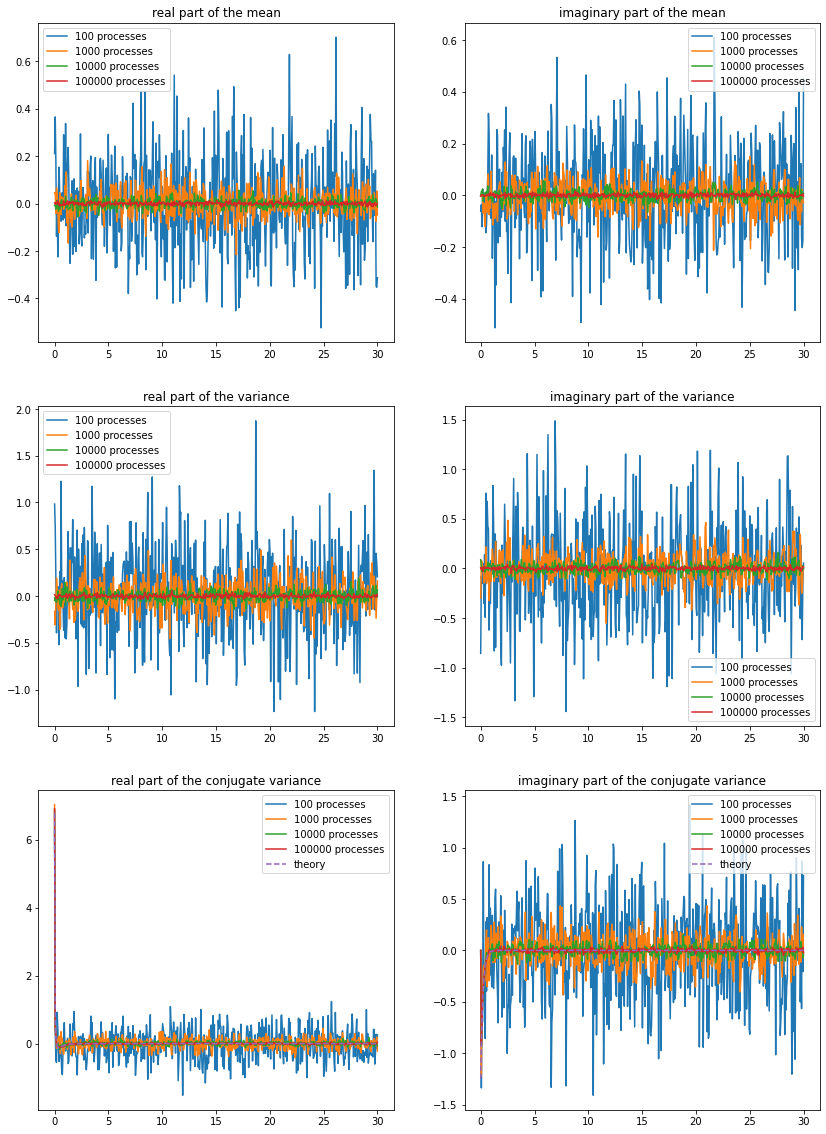

In [6]:
sample = lambda : generator.sample_process()
perform_noise_analysis(sample, ts, N_steps, [100, 1000, 10000, 100000], g_noise, w_noise, False)

# Test memory